## Realizar el Acceso a Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Instalación y Carga de Librerías para la actividad

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import requests
import heapq
import math
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise
from sklearn.decomposition import PCA
from PIL import Image
from io import BytesIO
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Carga de los datos para realizar el análisis**

In [ ]:
url = '/content/drive/My Drive/Tarea_SR/data/train.csv'
df1 = pd.read_csv(url  ,
                         sep=',',
                        index_col=None,
                         names=['user_id', 'item_id', 'timestamp'],
                         header=0
                  )

## Determinación de los 5 usuarios que son más activos

In [ ]:
import collections

prueba=df1.iloc[: , 0]
lista1=prueba.array

cuenta1 = collections.Counter(lista1)

#print(cuenta1)
mas_popular=cuenta1.most_common(5)

print(mas_popular)

[(566, 152), (350, 133), (103, 128), (144, 122), (1006, 122)]


## Cálculo de cantidad de usuarios 

In [ ]:
valor_id=list()
tabla_id=list()
cantidad_id=0
i=0

for id, valor in cuenta1.items():
    id=id
    cantidad_id=valor+cantidad_id
    valor_id.insert(id,valor)
    tabla_id.insert(id,id)

id1=id+1 


print("Cantidad de Usuarios: "+str(id1))

Cantidad de Usuarios: 1593


In [ ]:
df_item1=np.load('/content/drive/My Drive/Tarea_SR/data/resnet50_embeddings.npy', allow_pickle=True)

In [ ]:
df_items=pd.DataFrame.from_records(df_item1, columns =['item_id', 'embedding'])

In [ ]:
resnet50_featmat=df_items.iloc[:,1]

Se debe cambiar 'obj' a 'Array' para poder trabajar con los embeddings

In [ ]:
matriz=list()
for i in range(len(resnet50_featmat)):
 matriz.append(resnet50_featmat[i])


resnet50_featmat=np.array(matriz)

Cargar caracteristicas visuales pre-entrenadas: Redes ResNet50

En esta sección se trabajará con modelos pre-entrenados de redes convolucionales (CNN) que extraen caracteristicas visuales de las imagenes. 

Usaremos la arquitectura ResNet50

## Reducir la dimensionalidad de los embeddings de imágenes

* **Normalice los vectores**

### **Z-Score**

* Es una fórmula que permite la estandarización de una distribución.
* Esta fórmula se calcula restando al dato, la media de la distribución y dividiendo el resultado por la desviación típica (la distancia que tiene dicho dato respecto de la media).
* El resultado que arroja esta fórmula, permite conocer cuánto de lejos está un dato concreto respecto de la media. 
* Es una técnica que sirve para normalizar los datos lo que nos permite comparar comparar conjuntos de datos distintos, bien porque esté en unidades diferentes, bien porque se trate de volúmenes muy dispares.




* **normalización = ( x – media ) / desviación típica**

In [ ]:
def normalize_zscore_inplace(featmat):
    means = featmat.mean(0)
    stds = featmat.std(0)
    for i in range(stds.shape[0]):
        if stds[i] == 0:
            stds[i] = 1
    featmat -= means
    featmat /= stds

In [ ]:
index2id=tabla_id

In [ ]:
n_artworks = len(index2id)
#n_artworks=1593
resnet50_dim = resnet50_featmat.shape[1]

In [ ]:
resnet_prueba_featmat = np.empty(shape=(n_artworks, resnet50_dim ))

for i in range(n_artworks):
    resnet_prueba_featmat[i][:resnet50_dim] = resnet50_featmat[i]

    
normalize_zscore_inplace(resnet_prueba_featmat)

### **sklearn.decomposition.PCA**

* Principal component analysis (PCA)
* **class** sklearn.decomposition.PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
* Generando embeddings de tamaño 20 y 50.
* Compare los resultados de MAP@20 y nDCG@20 para ambas dimensiones.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

* **Aplique PCA, generando embeddings de tamaño 20 y 50.**

In [ ]:
# Project into a 20 PCA feature space
pca20_resnet_featmat = PCA(n_components=20).fit_transform(resnet_prueba_featmat)

print("Cantidad de features despues de PCA: ", pca20_resnet_featmat.shape[1])

Cantidad de features despues de PCA:  20


In [ ]:
# Project into a 50 PCA feature space
pca50_resnet_featmat = PCA(n_components=50).fit_transform(resnet_prueba_featmat)

print("Cantidad de features despues de PCA: ", pca50_resnet_featmat.shape[1])

Cantidad de features despues de PCA:  50


## **Latent Visual Features: Deep Neural Network Embedding (DNN)**

# Similar image retrieval

Transformar ID numericos a String

En esta sección utilizaremos los vectores cargados para hacer un sistema de recuperación o búsqueda de información, para diferentes métricas de distancia. El siguiente código es una clase utiliza de forma **interna** (no editar) para manejar las imágenes que verán despues.

In [ ]:
class _ImageHandler:

    def __init__(self):
        self._IMAGE_URLS = None
        self._IMAGES_CACHE = dict()

    def _load_image_urls(self):
        if self._IMAGE_URLS is None:
            with open('/content/drive/My Drive/Tarea_SR/data/artworkImageUrlsCache.json') as f:
                self._IMAGE_URLS = json.load(f)
    
    def _download_image(self, _id):
        url = self._IMAGE_URLS[str(_id)]['medium']
        try:
            r = requests.get(url, timeout=4)
        except requests.exceptions.Timeout:
            print('timeout detected for url = ', url)
            return False
        if r.status_code == 200:
            img = Image.open(BytesIO(r.content))
            self._IMAGES_CACHE[_id] = img
            return True
        else:
            print('unexpected r.status_code = %d for url = %s' % (r.status_code, url))
            return False
    
    def download_images(self, ids):
        missing_ids = [_id for _id in ids if _id not in self._IMAGES_CACHE]
        if len(missing_ids) == 0:
            return        
        self._load_image_urls()
        from concurrent.futures import ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=30) as executor:
            executor.map(self._download_image, missing_ids)
            executor.shutdown(wait=True)    

    def get_image(self, _id):
        try:
            img = self._IMAGES_CACHE[_id]
        except KeyError:
            self._load_image_urls()
            if self._download_image(_id):
                img = self._IMAGES_CACHE[_id]
            else:
                img = None
        return img

ImageHandler = _ImageHandler() # singleton instance

La siguiente función es para imprimir las imágenes en pantalla. **(no editar)**.

In [ ]:
def plot_images(ids):    
    plt.close()
    n = len(ids)
    nrows = math.ceil(n/5)
    ncols = min(n, 5)
    plt.figure(1, (20, 5 * nrows))

    ImageHandler.download_images(ids)
    for i, _id in enumerate(ids):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_yticks([])
        ax.set_xticks([])
        img = ImageHandler.get_image(_id)
        if img is None:
            ax.set_title('%d) id = %d not found' % (i, _id))
        else:
            ax.set_title('%d) id = %d' % (i, _id))
            ax.imshow(img, interpolation="nearest")
    plt.show()

La siguiente función busca las `topk` imágenes más cercanas según la métrica de distancia indicada. **no editar**.

In [ ]:
print('Loading past_transactions.pickle')
with open('/content/drive/My Drive/Tarea_SR/data/past_transactions.pickle', 'rb') as f:
    past_transactions = pickle.load(f)
    
print('Loading ground_truth.pickle')
with open('/content/drive/My Drive/Tarea_SR/data/ground_truth.pickle', 'rb') as f:
    ground_truth = pickle.load(f)    

Loading past_transactions.pickle
Loading ground_truth.pickle


Cantidad de usuarios distintos

In [ ]:
id2index = {_id:i for i,_id in enumerate(index2id)}

## Procedimiento para realizar recomendación por imágen

In [ ]:
# Find similar images by image id
def find_similar_images(embedding, query_id=None, metrics=('euclidean',), topk=5):
    assert len(metrics) > 0
    assert topk <= 30 # to avoid requesting too many images
    #n = embedding.shape[0]
    n = 1593
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = index2id[query_i]
    else:
        query_i = id2index[query_id]
        
    # --- show query image
    plt.title('query_id = %d' % query_id)
    plt.imshow(ImageHandler.get_image(query_id))
    plt.xticks([])
    plt.yticks([])
    plt.show()

    # --- show retrieved images for each metric
    for metric in metrics:
        print('-------- retrieved with metric = %s -----' % metric)
        distances = pairwise_distances(embedding[query_i].reshape(1,-1), embedding, metric=metric)
        heap = []
        for i in range(n):            
            if len(heap) < topk:
                heapq.heappush(heap, (-distances[0][i], i))
            else:
                heapq.heappushpop(heap, (-distances[0][i], i))
        heap.sort(reverse=True)
        rec_ids = [index2id[i] for _,i in heap]
        plot_images(rec_ids)
        print(rec_ids)

## Comparación con dos métricas diferentes

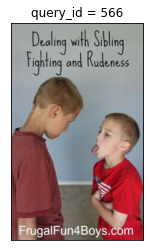

-------- retrieved with metric = cosine -----
unexpected r.status_code = 404 for url = http://niebla.ing.puc.cl/iic3633-2020/18b07a6816d358033e0f98173be413a2.jpg
unexpected r.status_code = 404 for url = http://niebla.ing.puc.cl/iic3633-2020/18b07a6816d358033e0f98173be413a2.jpg


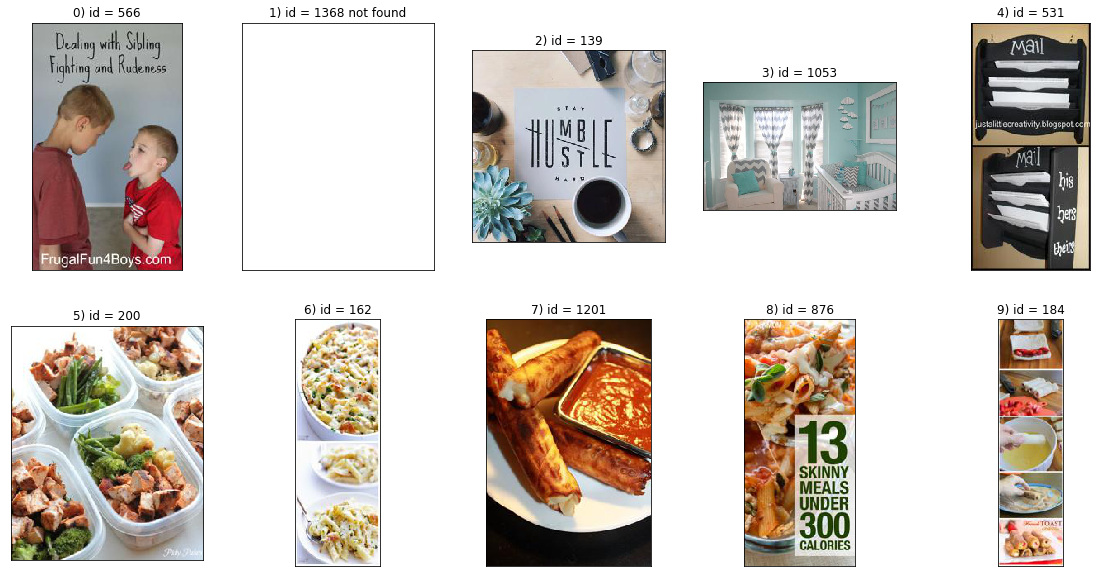

[566, 1368, 139, 1053, 531, 200, 162, 1201, 876, 184]
-------- retrieved with metric = euclidean -----
unexpected r.status_code = 404 for url = http://niebla.ing.puc.cl/iic3633-2020/18b07a6816d358033e0f98173be413a2.jpg
unexpected r.status_code = 404 for url = http://niebla.ing.puc.cl/iic3633-2020/333066c091165a2088cce550510890aa.jpg
unexpected r.status_code = 404 for url = http://niebla.ing.puc.cl/iic3633-2020/18b07a6816d358033e0f98173be413a2.jpg
unexpected r.status_code = 404 for url = http://niebla.ing.puc.cl/iic3633-2020/333066c091165a2088cce550510890aa.jpg


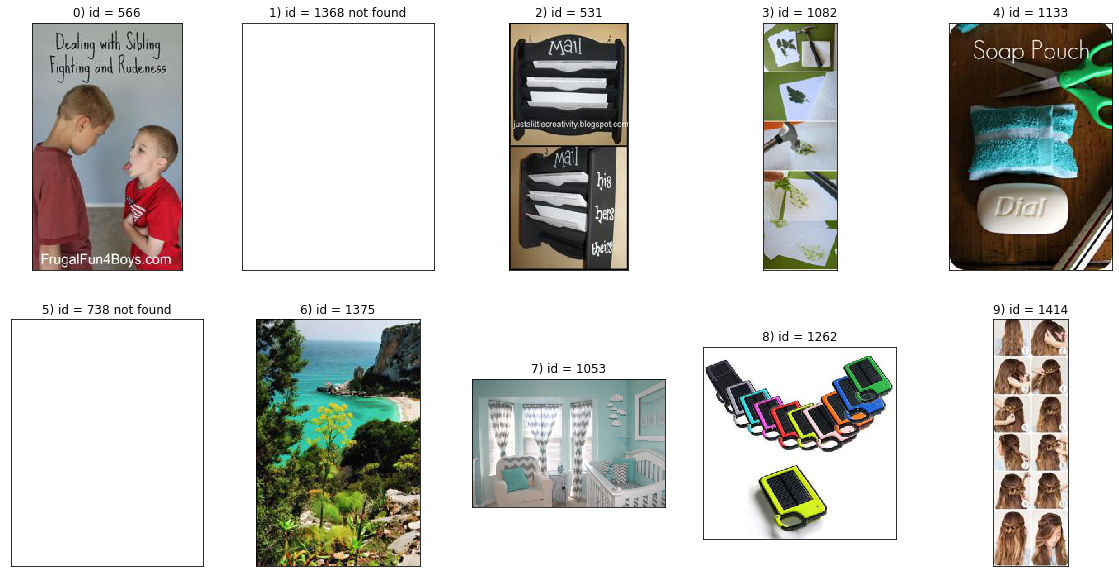

[566, 1368, 531, 1082, 1133, 738, 1375, 1053, 1262, 1414]


In [ ]:
find_similar_images(pca20_resnet_featmat, metrics=('cosine','euclidean'), query_id=566, topk=10)

**Esta forma de ranking funciona bien para datasets pequeños, para cosas de mayor tamaño pruebe con cosas como [Annoy](https://github.com/spotify/annoy)**

## Usando ResNet50

# Recomendaciones

El de recomendación para un usuario del siguiente modo:

1. Para cada transacción del usuario, se calcula la distancia entre la pintura comprada y todas las demás ítems posibles a recomendar. 
2. Se busca aquella transacción que tenga la mínima distancia posible a todos los demás ítems
3. Se recomienda las pinturas utilizando la distancia de la transacción obtenida en el punto 2. Para esto se van entregando las pinturas que tienen menor distancia a esta. A medida que aumenta la recomiendación, la distancia aumenta. 

Para el ordenamiento se utilizó el algoritmo [`heapsort`](https://es.wikipedia.org/wiki/Heapsort).

## Ejemplos de recomendación

Diseñado especialmente para recomendación de imágenes considerando igualmente filtrado colaborativo. Recuerde generar 10 recomendaciones para cada usuario del set de test, en el mismo formato solicitado antes, y entregar en formato json para que el equipo docente haga un ranking de los mejores grupos.

In [ ]:
def recommend(embedding, query_id=None, topk=10, metrics='cosine'):
  
    assert len(metrics) > 0
    assert topk <= 30 # to avoid requesting too many images
    #n = embedding.shape[0]
    n = 1593
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = index2id[query_i]
    else:
        query_i = id2index[query_id]

    print("user_id = ", query_id)
    
# --- show query image
    plt.title('query_id = %d' % query_id)
    plt.imshow(ImageHandler.get_image(query_id))
    plt.xticks([])
    plt.yticks([])
    plt.show()


 # --- show retrieved images for each metric
    for metric in metrics:
        #print('-------- retrieved with metric = %s -----' % metric)
        distances = pairwise_distances(embedding[query_i].reshape(1,-1), embedding, metric=metrics)

        distances = np.minimum(distances, pairwise_distances(embedding[query_i].reshape(1,-1), embedding, metric=metrics).reshape(-1))

        


        heap = []
        for i in range(n):            
            if len(heap) < topk:
                heapq.heappush(heap, (-distances[0][i], i))
            else:
                heapq.heappushpop(heap, (-distances[0][i], i))
        heap.sort(reverse=True)
        rec_ids = [index2id[i] for _,i in heap]
        
        #plot_images(rec_ids)
        #print(heap)

    
    
    # utilizamos un heap para extraer los items ordenados de menor a mayor distancia 
    recommended_ids = [index2id[i] for _,i in heap]
    
    #Show consumed items
    #print('\t\t\t\t============ Consumed items =============\n\n')
    #plot_images(trx)

    #Show recommended items
    print('\n\n\n\t\t\t\t============ Recommended items =============\n\n')
    plot_images(recommended_ids)
    return recommended_ids

user_id =  566


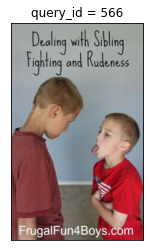




				============ Recommended items =============


unexpected r.status_code = 404 for url = http://niebla.ing.puc.cl/iic3633-2020/18b07a6816d358033e0f98173be413a2.jpg
unexpected r.status_code = 404 for url = http://niebla.ing.puc.cl/iic3633-2020/18b07a6816d358033e0f98173be413a2.jpg


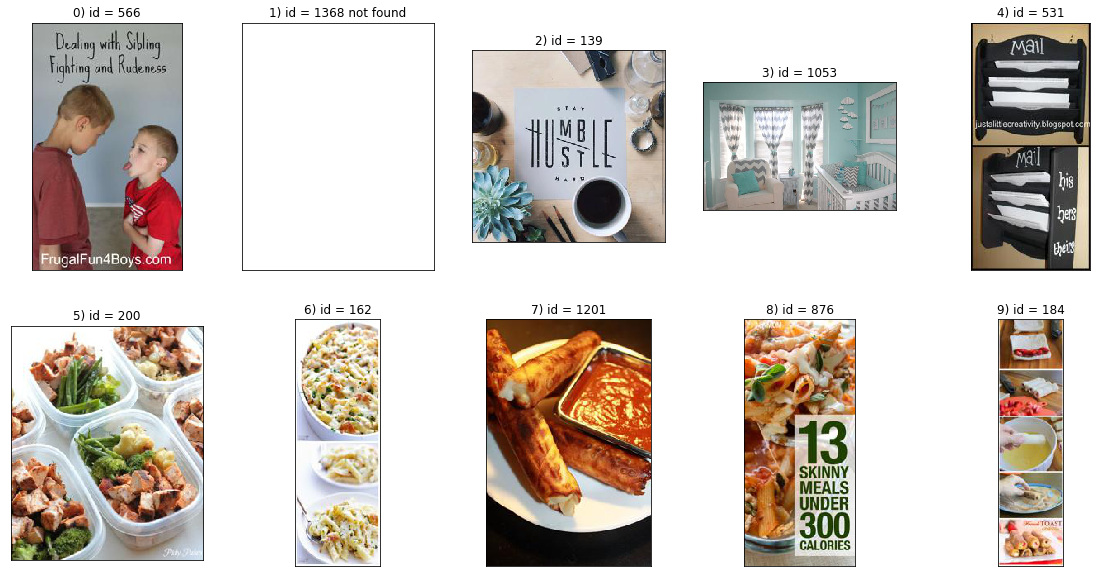

In [ ]:
rec = recommend(pca20_resnet_featmat, query_id=566, topk=10, metrics='cosine')

# **Desarrollo de las Métricas Score para la actividad**

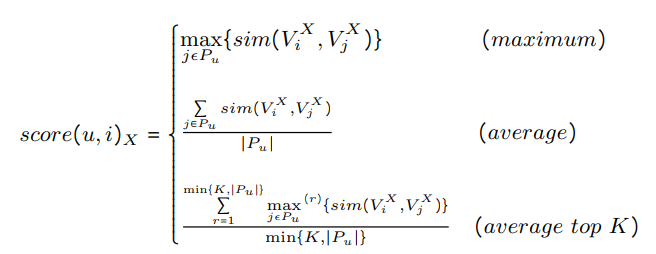

## **SCORE MAX**

## Desarrollo del score MAX 

In [ ]:
def recommend_Score_MAX(embedding, query_id=None, topk=10, metrics='cosine'):
  
    assert len(metrics) > 0
    assert topk <= 30 # to avoid requesting too many images
    #n = embedding.shape[0]
    n = 1593
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = index2id[query_i]
    else:
        query_i = id2index[query_id]

    print("user_id = ", query_id)
    
# --- show query image
    plt.title('query_id = %d' % query_id)
    plt.imshow(ImageHandler.get_image(query_id))
    plt.xticks([])
    plt.yticks([])
    plt.show()


 # --- show retrieved images for each metric
    for metric in metrics:
       
        distances = pairwise.cosine_similarity(embedding[query_i].reshape(1,-1), embedding)
       

        heap = []
        for i in range(n):            
            if len(heap) < topk:
                heapq.heappush(heap, (-distances[0][i], i))
            else:
                heapq.heappushpop(heap, (-distances[0][i], i))
        heap.sort(reverse=True)
        rec_ids = [index2id[i] for _,i in heap]
        
        
    # utilizamos un heap para extraer los items ordenados de menor a mayor distancia 
    recommended_ids = [index2id[i] for _,i in heap]
    
    
    #Show recommended items
    print('\n\n\n\t\t\t\t============ Recommended items =============\n\n')
    plot_images(recommended_ids)
    return recommended_ids

## Desarrollo score MAX para obtener el valor del ID

In [ ]:
def recommend_Score_MAX_List(embedding, query_id=None, topk=10, metrics='cosine'):
  
    assert len(metrics) > 0
    assert topk <= 30 # to avoid requesting too many images
    #n = embedding.shape[0]
    n = 1593
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = index2id[query_i]
    else:
        query_i = id2index[query_id]

    

 # --- show retrieved images for each metric
    for metric in metrics:
        distances = pairwise.cosine_similarity(embedding[query_i].reshape(1,-1), embedding)
        

        heap = []
        for i in range(n):            
            if len(heap) < topk:
                heapq.heappush(heap, (-distances[0][i], i))
            else:
                heapq.heappushpop(heap, (-distances[0][i], i))
        heap.sort(reverse=True)
        rec_ids = [index2id[i] for _,i in heap]
       
        
    # utilizamos un heap para extraer los items ordenados de menor a mayor distancia 
    recommended_ids = [index2id[i] for _,i in heap]

    
    return recommended_ids

In [ ]:
recommend_Score_MAX_List(pca50_resnet_featmat, query_id=566, topk=10, metrics='cosine')

[643, 621, 956, 1242, 66, 929, 231, 63, 47, 1566]

user_id =  566


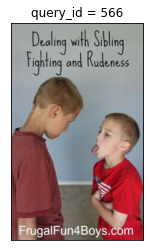




				============ Recommended items =============


unexpected r.status_code = 404 for url = http://niebla.ing.puc.cl/iic3633-2020/3edb9b4777fdbf3dcdc037b912f941c5.jpg
unexpected r.status_code = 404 for url = http://niebla.ing.puc.cl/iic3633-2020/3edb9b4777fdbf3dcdc037b912f941c5.jpg


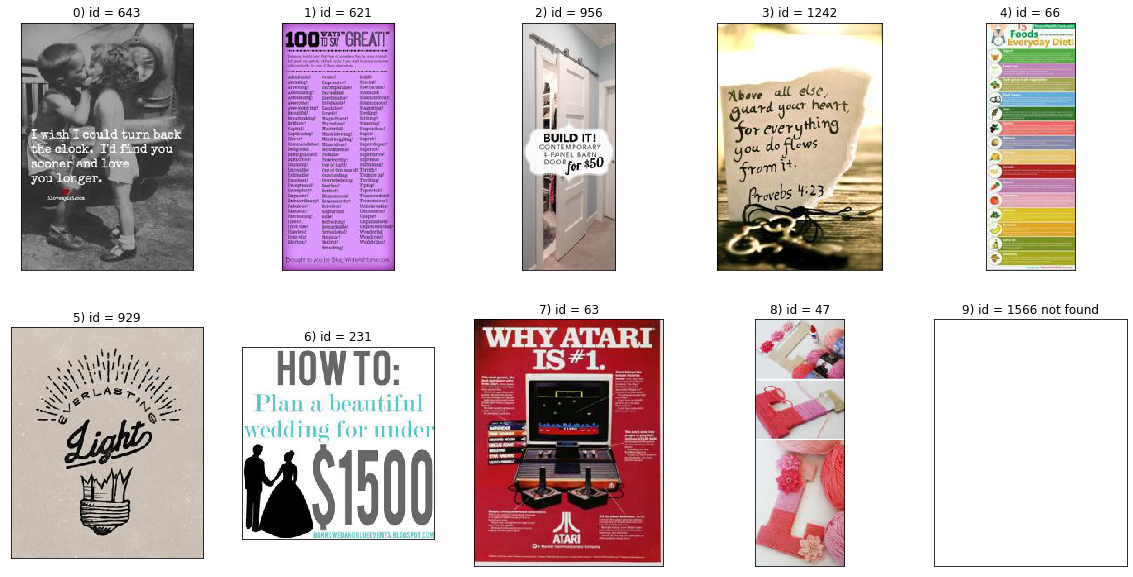

[643, 621, 956, 1242, 66, 929, 231, 63, 47, 1566]

In [ ]:
recommend_Score_MAX(pca50_resnet_featmat, query_id=566, topk=10)

## **SCORE AVERAGE**

## Desarrollo de la métrica para el método score AVERAGE

In [ ]:
def Score_Average(embedding1, embedding, query_i):
  embedding2=(embedding[1].reshape(1,-1))*0
  embedding2=embedding1
  vector2=np.array(embedding)
  simi=pairwise.cosine_similarity(embedding[2].reshape(1,-1), embedding)*0
  simi2=pairwise.cosine_similarity(embedding[2].reshape(1,-1), embedding)*0

  for i in range(len(embedding[1])-1):
    for j in range(len(embedding)-1):
      simi[0][i]=np.dot(embedding2[0][i],vector2[j][i])
      simi2=simi+simi2

     
  return simi2/len(embedding)

### Implemetando la métrica anterior en el recomendador

In [ ]:
def recommend_Score_Average(embedding, query_id=None, topk=10, metrics='cosine'):
  
    assert len(metrics) > 0
    assert topk <= 30 # to avoid requesting too many images
    #n = embedding.shape[0]
    n = 1593
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = index2id[query_i]
    else:
        query_i = id2index[query_id]

    print("user_id = ", query_id)
    
# --- show query image
    plt.title('query_id = %d' % query_id)
    plt.imshow(ImageHandler.get_image(query_id))
    plt.xticks([])
    plt.yticks([])
    plt.show()


 # --- show retrieved images for each metric
    for metric in metrics:
        #print('-------- retrieved with metric = %s -----' % metric)
        
        distances = Score_Average(embedding[query_i].reshape(1,-1),embedding,query_id)
       

        heap = []
        for i in range(n):            
            if len(heap) < topk:
                heapq.heappush(heap, (-distances[0][i], i))
            else:
                heapq.heappushpop(heap, (-distances[0][i], i))
        heap.sort(reverse=True)
        rec_ids = [index2id[i] for _,i in heap]
        
    
    
    # utilizamos un heap para extraer los items ordenados de menor a mayor distancia 
    recommended_ids = [index2id[i] for _,i in heap]
    
    #Show recommended items
    print('\n\n\n\t\t\t\t============ Recommended items =============\n\n')
    plot_images(recommended_ids)
    return recommended_ids

## Recomendador que solo entrega la lista

In [ ]:
def recommend_Score_Average_List(embedding, query_id=None, topk=10, metrics='cosine'):
  
    assert len(metrics) > 0
    assert topk <= 30 
    #n = embedding.shape[0]
    n = 1593
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = index2id[query_i]
    else:
        query_i = id2index[query_id]



 # --- show retrieved images for each metric
    for metric in metrics:
       
        distances = Score_Average(embedding[query_i].reshape(1,-1),embedding,query_id)
        

        heap = []
        for i in range(n):            
            if len(heap) < topk:
                heapq.heappush(heap, (-distances[0][i], i))
            else:
                heapq.heappushpop(heap, (-distances[0][i], i))
        heap.sort(reverse=True)
        rec_ids = [index2id[i] for _,i in heap]
        
    
    
    # utilizamos un heap para extraer los items ordenados de menor a mayor distancia 
    recommended_ids = [index2id[i] for _,i in heap]
    
    
    return recommended_ids

In [ ]:
recommend_Score_Average_List(pca20_resnet_featmat, query_id=566, topk=15, metrics='cosine')

[1, 13, 4, 8, 10, 7, 12, 14, 16, 1592, 1591, 1590, 1589, 1588, 1587]

user_id =  566


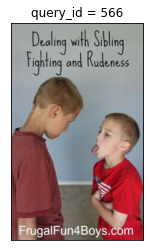




				============ Recommended items =============




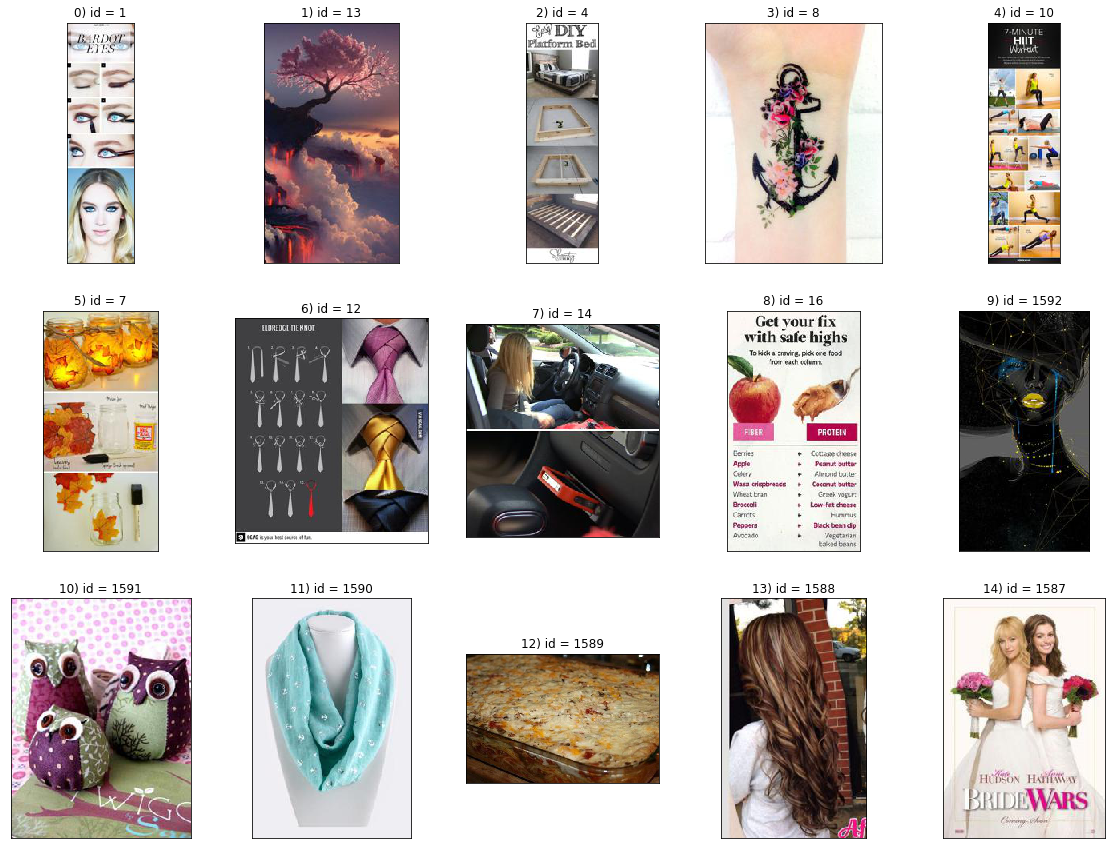

[1, 13, 4, 8, 10, 7, 12, 14, 16, 1592, 1591, 1590, 1589, 1588, 1587]

In [ ]:
recommend_Score_Average(pca20_resnet_featmat, query_id=566, topk=15, metrics='cosine')

## **SCORE AVERAGE TOP K**

## Desarrollo de la métrica para score AVERAGE TOP K

In [ ]:
def Score_Average_TK(embedding1, embedding, query_i,K=1000):
  embedding2=(embedding[1].reshape(1,-1))*0
  embedding2=embedding1
  vector2=np.array(embedding)
  simi=pairwise.cosine_similarity(embedding[2].reshape(1,-1), embedding)*0
  simi2=pairwise.cosine_similarity(embedding[2].reshape(1,-1), embedding)*0
  Total=0

  if K<len(embedding):
    for i in range(len(embedding[1])-1):
      for j in range(K):
        simi[0][i]=np.dot(embedding2[0][i],vector2[j][i])
        simi2=simi+simi2

      Total=simi2/K

    else: 
     for i in range(len(embedding[1])-1):
       for j in range(len(embedding)-1):
         simi[0][i]=np.dot(embedding2[0][i],vector2[j][i])
         simi2=simi+simi2
       Total=simi2/len(embedding)
     
  return Total

## Implementación de la métrica en el recomendador

In [ ]:
def recommend_Score_Average_TK(embedding, query_id=None, topk=10, metrics='cosine', K1=100):
  
    assert len(metrics) > 0
    assert topk <= 30 # to avoid requesting too many images
    #n = embedding.shape[0]
    n = 1593
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = index2id[query_i]
    else:
        query_i = id2index[query_id]

    print("user_id = ", query_id)
    
# --- show query image
    plt.title('query_id = %d' % query_id)
    plt.imshow(ImageHandler.get_image(query_id))
    plt.xticks([])
    plt.yticks([])
    plt.show()


 # --- show retrieved images for each metric
    for metric in metrics:
        #print('-------- retrieved with metric = %s -----' % metric)
        
        distances = Score_Average_TK(embedding[query_i].reshape(1,-1),embedding,query_id,K1)


        heap = []
        for i in range(n):            
            if len(heap) < topk:
                heapq.heappush(heap, (-distances[0][i], i))
            else:
                heapq.heappushpop(heap, (-distances[0][i], i))
        heap.sort(reverse=True)
        rec_ids = [index2id[i] for _,i in heap]
        
    
    
    # utilizamos un heap para extraer los items ordenados de menor a mayor distancia 
    recommended_ids = [index2id[i] for _,i in heap]
    
    

    #Show recommended items
    print('\n\n\n\t\t\t\t============ Recommended items =============\n\n')
    plot_images(recommended_ids)
    return recommended_ids

## Recomendador para obtener solo las recomendaciones

In [ ]:
def recommend_Score_Average_TK_List(embedding, query_id=None, topk=10, metrics='cosine', K1=100):
  
    assert len(metrics) > 0
    assert topk <= 30 # to avoid requesting too many images
    #n = embedding.shape[0]
    n = 1593
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = index2id[query_i]
    else:
        query_i = id2index[query_id]


 # --- show retrieved images for each metric
    for metric in metrics:
        
        distances = Score_Average_TK(embedding[query_i].reshape(1,-1),embedding,query_id,K1)
        

        heap = []
        for i in range(n):            
            if len(heap) < topk:
                heapq.heappush(heap, (-distances[0][i], i))
            else:
                heapq.heappushpop(heap, (-distances[0][i], i))
        heap.sort(reverse=True)
        rec_ids = [index2id[i] for _,i in heap]
        
    
    # utilizamos un heap para extraer los items ordenados de menor a mayor distancia 
    recommended_ids = [index2id[i] for _,i in heap]
    
    
    return recommended_ids

In [ ]:
recommend_Score_Average_TK_List(pca20_resnet_featmat, query_id=566, topk=10, K1=350)

[13, 18, 0, 7, 8, 10, 15, 11, 1592, 1591]

user_id =  566


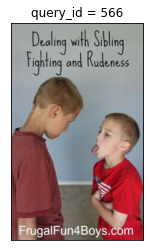




				============ Recommended items =============




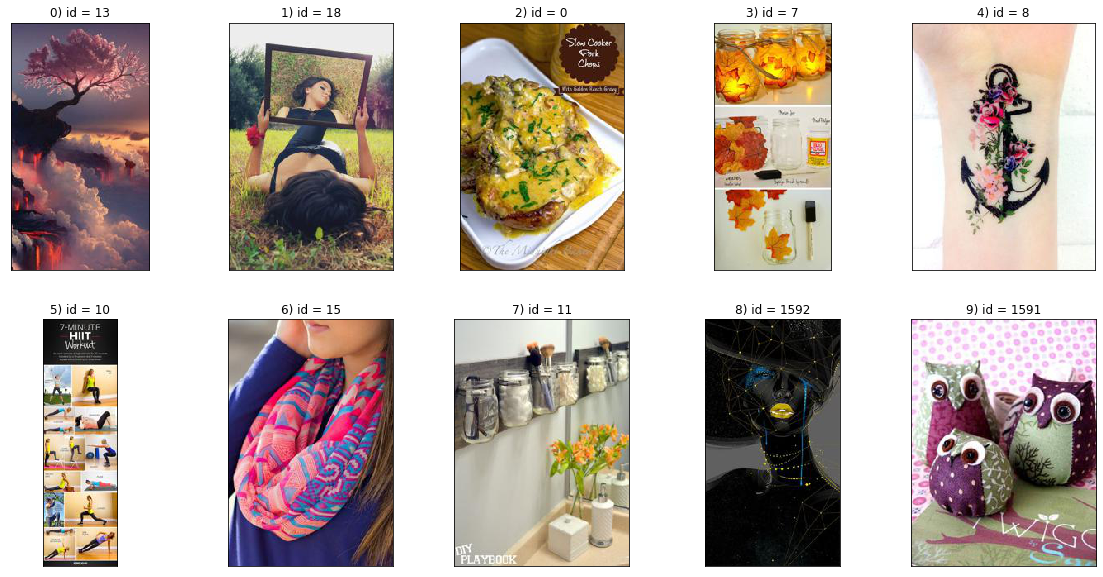

[13, 18, 0, 7, 8, 10, 15, 11, 1592, 1591]

In [ ]:
recommend_Score_Average_TK(pca20_resnet_featmat, query_id=566, topk=10, K1=350)

# **Creación de Archivo JSON con Recoemdaciones por contenido**

In [ ]:
import numpy
filename = "/content/drive/My Drive/Tarea_SR/data/Tr1.csv"
raw_data = open(filename)
data = numpy.loadtxt(raw_data, delimiter=",",skiprows=0,dtype ='str')


def cambio(ID_imagen):
  transfor=data[ID_imagen][1]
  return transfor

In [ ]:
# Cargamos el dataset con los items
user_items_test = pd.read_csv('/content/drive/My Drive/Tarea_SR/data/test_users.csv',
                        sep=';',
                        names = ['user_id'],
                        header=None 
                        )

In [ ]:
valores =[]
#adj = ["1","2","3","4"]
#adj=crear_fila1(pruebam)
#crear_fila=[0,1,2,3,4,5]
m=20

for i in range(len(user_items_test)):
  ListaP=pd.DataFrame.to_numpy(user_items_test)
  valores.append(int(ListaP[i]))





In [ ]:
data1={}

for x in range(len(valores)):
  data1["user_"+str(valores[x])] = []
  data1["user_"+str(valores[x])].append(recommend_Score_MAX_List(pca20_resnet_featmat, query_id=valores[x], topk=20, metrics='cosine'))

In [ ]:
data2={}

for x in range(len(valores)):
  data2["user_"+str(valores[x])] = []
  
  data2["user_"+str(valores[x])].append(recommend_Score_Average_List(pca20_resnet_featmat, query_id=valores[x], topk=10, metrics='cosine'))

In [ ]:
data3={}
#model = model_bpr_200_01_001
for x in range(len(valores)):
  data3["user_"+str(valores[x])] = []
  #recommend_Score_Average_TK_List(pca20_resnet_featmat, query_id=valores[x], topk=20, K1=350)
  #recommend_Score_Average_List(pca20_resnet_featmat, query_id=valores[x], topk=20, metrics='cosine')
  data3["user_"+str(valores[x])].append(recommend_Score_Average_TK_List(pca20_resnet_featmat, query_id=valores[x], topk=20, metrics='cosine', K1=350))

In [ ]:
archivo=open('prueba_guardar.txt','w')
guardar = str(data1)
archivo.write(guardar)
archivo.close()


In [ ]:
archivo=open('prueba_guardar10.txt','w')
guardar = str(data2)
archivo.write(guardar)
archivo.close()

In [ ]:
archivo=open('prueba_guardar2.txt','w')
guardar = str(data3)
archivo.write(guardar)
archivo.close()